# Recurrent Neural Network for learning embeddings of products

We use Recurrent Neural Network to learn about time-series data. In this course work, we first grouped those data by some interval times to construct time-series sequence data.

The attributes used for features of sequence data include:
1. `revenue`: total revenues of products in the interval
2. `average_unit_price`: average cost of a single item. The price policy may change by stage
3. `profit`: total profit of products in the interval
4. `profit_margin`: compute by profit divide revenue
5. `nunique_customer`: compute by number of distinct customer purchase in this interval
6. `order_frequency`: compute by number of order include this item
7. `avg_quantity_sold`: avarage quanity purchased per each order

## A. Load the data

In [1]:
import pandas as pd

factProductSales_df = pd.read_csv('data/factProductSales_enriched.csv')

factProductSales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121234 entries, 0 to 121233
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ProductID     121234 non-null  int64  
 1   OrderQty      121234 non-null  int64  
 2   LineTotal     121234 non-null  float64
 3   SalesOrderID  121234 non-null  int64  
 4   OrderDate     121234 non-null  object 
 5   CustomerID    121234 non-null  int64  
 6   StandardCost  121234 non-null  float64
 7   profit        121234 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 7.4+ MB


## B. Feature Engineering

In this stage, we process and group the data to get feature matrix:
- `profit`: total profit that a single product have returned
- `profit_margin`: total profit that a single product have returned
- `revenue`: total money that a product make (sum of line total)
- `average_unit_price`: average price of a product, compute as division of total LineTotal by OrderQty
- `order_frequency`: number of orders that do have this product
- `avg_quantity_sold`: average number of quantity that each order purchase, compute as division of total OrderQty by order_frequency
- `nunique_customer`: number of unique customer purchase at least 1 item of this product

### Group the order date by quarter

In [2]:
from datetime import datetime

class QuarterFormatter:
    year: int
    quarter: int

    def __init__(self, year: int, quarter: int):
        self.year = year
        self.quarter = quarter

    @staticmethod
    def get_quarter(date_str: datetime):
        return QuarterFormatter(
            year=date_str.year,
            quarter=((date_str.month - 1) // 3) + 1
        )
    
    def __sub__(self, other: 'QuarterFormatter') -> int:
        return (self.year - other.year) * 4 + (self.quarter - other.quarter)
    
    def __str__(self) -> str:
        return f"{self.year}-Q{self.quarter}"

    def __repr__(self) -> str:
        return self.__str__()
    
    def __eq__(self, other: object) -> bool:
        if not isinstance(other, QuarterFormatter):
            return False
        return self.year == other.year and self.quarter == other.quarter

    def __hash__(self) -> int:
        return hash((self.year, self.quarter))
    
    def __lt__(self, other: 'QuarterFormatter') -> bool:
        if self.year != other.year:
            return self.year < other.year
        return self.quarter < other.quarter

    def __le__(self, other: 'QuarterFormatter') -> bool:
        return self < other or self == other

factProductSales_df['Quarter'] = pd.to_datetime(factProductSales_df['OrderDate']).apply(QuarterFormatter.get_quarter)
factProductSales_df[factProductSales_df['ProductID'] == 707]['Quarter'].unique()

array([2011-Q2, 2011-Q3, 2011-Q4, 2012-Q1, 2012-Q2, 2012-Q3, 2012-Q4,
       2013-Q1, 2013-Q2, 2013-Q3, 2013-Q4, 2014-Q1, 2014-Q2], dtype=object)

#### Group the result by quarter

In [3]:
from datetime import datetime

product_df = factProductSales_df.groupby(['ProductID', 'Quarter']).aggregate({
    'OrderQty': 'sum',
    'LineTotal': 'sum',
    'profit': 'sum',
    'CustomerID': 'nunique',
    'SalesOrderID': 'nunique'
}).rename(columns={
    'CustomerID': 'nunique_customer',
    'SalesOrderID': 'order_frequency',
    'LineTotal': 'revenue'
}).reset_index()

product_df['average_unit_price'] = product_df['revenue'] / product_df['OrderQty']
product_df['profit_margin'] = product_df['profit'] / product_df['revenue']
product_df['avg_quantity_sold'] = product_df['OrderQty'] / product_df['order_frequency']
product_df.drop(columns=['OrderQty'], inplace=True)

product_df.head()

,ProductID,Quarter,revenue,profit,nunique_customer,order_frequency,average_unit_price,profit_margin,avg_quantity_sold
0,707,2011-Q2,322.984000,94.455800,9,9,16.999158,0.292447,2.111111
1,707,2011-Q3,3108.721000,1256.439800,57,57,20.186500,0.404166,2.701754
2,707,2011-Q4,3088.534500,1248.281100,51,51,20.186500,0.404166,3.000000
3,707,2012-Q1,3653.756500,1476.724700,51,62,20.186500,0.404166,2.919355
4,707,2012-Q2,7807.386772,1963.737972,104,104,18.241558,0.251523,4.115385


### Filter out those not active products

In [4]:
# Currently considering quarters from 2014-Q2 to 2019-Q4
ACTIVE_QUARTER = QuarterFormatter(year=2014, quarter=2)

# Filter out products that do not active until 2014-Q2
final_dates = product_df.groupby('ProductID').aggregate({
    'Quarter': 'max'
})
active_products = final_dates[final_dates['Quarter'] >= ACTIVE_QUARTER].index
product_df = product_df[product_df['ProductID'].isin(active_products)].reset_index(drop=True)

print("Number of active products:", len(active_products))

product_df.info()

Number of active products: 166
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ProductID           1069 non-null   int64  
 1   Quarter             1069 non-null   object 
 2   revenue             1069 non-null   float64
 3   profit              1069 non-null   float64
 4   nunique_customer    1069 non-null   int64  
 5   order_frequency     1069 non-null   int64  
 6   average_unit_price  1069 non-null   float64
 7   profit_margin       1069 non-null   float64
 8   avg_quantity_sold   1069 non-null   float64
dtypes: float64(5), int64(3), object(1)
memory usage: 75.3+ KB


## C. Train the LSTM Autoencoder to take into account time-series data

### Prepare Data Loader

### Establish the data into time-series sequencing data

Number of sequences: 166


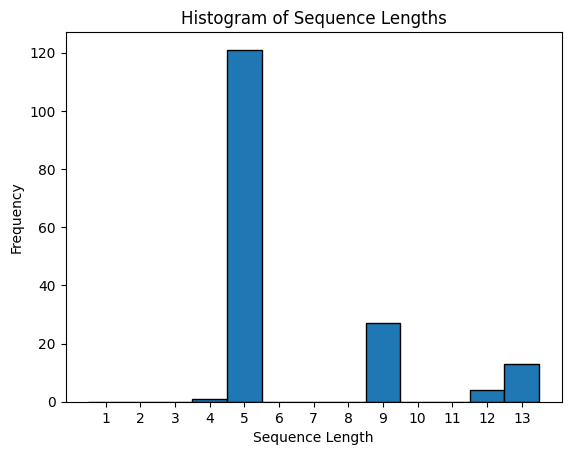

In [5]:
import numpy as np
import matplotlib.pyplot as plt

FEATURES = ['revenue', 'profit', 'profit_margin', 'nunique_customer', 
            'order_frequency', 'average_unit_price', 'avg_quantity_sold']

sequences_data = []
for product_id in active_products:
    data_slice = product_df[product_df['ProductID'] == product_id].sort_values(by='Quarter')
    data_slice = data_slice[FEATURES].to_numpy()
    sequences_data.append(data_slice)

print("Number of sequences:", len(sequences_data))
# Plotting histogram for length of sequences
sequence_lengths = [len(seq) for seq in sequences_data]
plt.hist(sequence_lengths, bins=np.arange(1, max(sequence_lengths)+2)-0.5, edgecolor='black')
plt.title("Histogram of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.xticks(range(1, max(sequence_lengths)+1))
plt.show()

## C. Build RNN model to learn vector representation

In [6]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class Encoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 1):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True
        )

        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, padded_X: torch.Tensor, lengths: torch.Tensor):
        """
        Args:
            padded_X: (batch_size, seq_len, input_size)
            lengths: (batch_size) - Length of each sequence
        Returns:
            hidden_state: The final hidden state (embedding) of the last layer.
        """
        # Pack the sequence to ignore padding during encoding
        packed_X = rnn_utils.pack_padded_sequence(
            padded_X, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # Pass through LSTM
        _, (h_n, _) = self.lstm(packed_X)
        
        # Extract the output of the last layer to serve as the embedding
        embedding = h_n[-1]                         # h_n shape: (num_layers, batch_size, hidden_size)
        embedding = self.layer_norm(embedding)

        return embedding

class Decoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int = 1):
        super(Decoder, self).__init__()
        # Note: The input to the decoder LSTM is the embedding size (hidden_size of encoder)
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, embedding: torch.Tensor, lengths: torch.Tensor, max_len: int):
        """
        Args:
            embedding: (batch_size, hidden_size) - The compressed representation
            lengths: (batch_size) - Original lengths to repack correctly
            max_len: int - The maximum length to reconstruct
        """
        # 1. Repeat Vector Strategy
        # We repeat the embedding 'max_len' times to create the input for the Decoder.
        # Input shape becomes: (batch_size, max_len, hidden_size)
        decoder_input = embedding.unsqueeze(1).repeat(1, max_len, 1)
        
        # 2. Pack the repeated input
        packed_input = rnn_utils.pack_padded_sequence(
            decoder_input, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # 3. Pass through Decoder LSTM
        # We do NOT pass the encoder hidden state here. We let the LSTM learn to reconstruct purely from the input sequence of embeddings.
        packed_out, _ = self.lstm(packed_input)
        
        # 4. Unpack
        out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True, total_length=max_len)          # out shape: (batch_size, max_len, hidden_size)
        
        # 5. Project back to original feature space
        reconstruction = self.linear(out)
        
        return reconstruction

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 1):
        super(LSTMAutoencoder, self).__init__()
        
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(input_size=hidden_size, hidden_size=hidden_size, output_size=input_size, num_layers=num_layers)
        
    def forward(self, padded_X: torch.Tensor, lengths: torch.Tensor):
        embedding = self.encoder(padded_X, lengths)

        max_len = padded_X.shape[1]                     # For the decoder to know how much to pad/reconstruct
        reconstructed = self.decoder(embedding, lengths, max_len)
        
        return reconstructed, embedding
    
    def encode(self, padded_X: torch.Tensor, lengths: torch.Tensor):
        return self.encoder(padded_X, lengths)

### Prepare Dataloader

In [7]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

class SequenceDataset(Dataset):
    def __init__(self, sequences: list[torch.Tensor]):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

def collate_fn_with_padding(batch):
    lengths = torch.tensor([len(seq) for seq in batch])
    padded_sequences = pad_sequence(batch, batch_first=True, padding_value=0)
    return padded_sequences, lengths

# Normalize each feature across all sequences
all_data = np.vstack(sequences_data)
scaled_sequences_data = StandardScaler().fit_transform(all_data)
split_indices = np.cumsum([len(seq) for seq in sequences_data])[:-1]
scaled_sequences_data = np.split(scaled_sequences_data, split_indices)

sequences_data_tensor = [torch.tensor(seq, dtype=torch.float32) for seq in scaled_sequences_data]
sequence_dataloader = DataLoader(SequenceDataset(sequences_data_tensor), batch_size=32, shuffle=True, collate_fn=collate_fn_with_padding)
model = LSTMAutoencoder(input_size=len(FEATURES), hidden_size=48, num_layers=1)

In [8]:
from tqdm import tqdm

def train_step(model: LSTMAutoencoder, dataloader: DataLoader, optimizer: torch.optim.Optimizer, criterion: torch.nn.Module):
    model.train()
    total_loss = 0

    for padded_X, lengths in dataloader:
        # padded_X: (batch, max_len, features)
        
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed, _ = model(padded_X, lengths)
        
        # 1. Create a boolean mask of shape (batch, max_len)
        mask = torch.arange(padded_X.size(1))[None, :] < lengths[:, None]
        
        # 2. Expand mask to cover feature dimensions
        # Shape becomes (batch, max_len, features)
        mask = mask.unsqueeze(-1).expand_as(padded_X)
        
        # 3. Apply mask to both output and target
        # We select only the valid elements
        masked_output = reconstructed[mask]
        masked_target = padded_X[mask]
        
        # 4. Calculate loss only on valid elements
        loss = criterion(masked_output, masked_target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=5e-4)
criterion = nn.MSELoss()
NOTIFY_EVERY = 50

for epoch in range(1000):
    avg_loss = train_step(model, sequence_dataloader, optimizer, criterion)
    if (epoch + 1) % NOTIFY_EVERY == 0:
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

print("Training complete !")

Epoch 50, Average Loss: 0.1200
Epoch 100, Average Loss: 0.0728
Epoch 150, Average Loss: 0.0358
Epoch 200, Average Loss: 0.0330
Epoch 250, Average Loss: 0.0228
Epoch 300, Average Loss: 0.0164
Epoch 350, Average Loss: 0.0151
Epoch 400, Average Loss: 0.0124
Epoch 450, Average Loss: 0.0116
Epoch 500, Average Loss: 0.0126
Epoch 550, Average Loss: 0.0113
Epoch 600, Average Loss: 0.0120
Epoch 650, Average Loss: 0.0090
Epoch 700, Average Loss: 0.0093
Epoch 750, Average Loss: 0.0089
Epoch 800, Average Loss: 0.0095
Epoch 850, Average Loss: 0.0109
Epoch 900, Average Loss: 0.0062
Epoch 950, Average Loss: 0.0063
Epoch 1000, Average Loss: 0.0049
Training complete !


### Get the embeddings 

In [9]:
lengths_list = torch.tensor([len(seq) for seq in sequences_data_tensor])

padded_sequences = pad_sequence(sequences_data_tensor, batch_first=True, padding_value=0)
with torch.no_grad():
    embeddings = model.encode(padded_sequences, lengths_list)

print("Embeddings shape:", embeddings.shape)  # Should be (num_sequences, hidden_size)
print("First 4 embeddings:")
print(embeddings[:4, :5])

Embeddings shape: torch.Size([166, 48])
First 4 embeddings:
tensor([[ 0.0166, -0.7963, -0.4245,  1.1462, -0.3419],
        [ 0.0516, -0.9022, -0.4260,  1.0686, -0.3277],
        [ 0.0115, -0.7251, -0.4249,  1.1009, -0.2504],
        [ 0.0821, -0.7058, -0.1600,  0.6212,  0.1498]])


### Saved embeddings

In [15]:
embeddings_df = pd.DataFrame(embeddings.numpy())
embeddings_df['ProductID'] = active_products.values
embeddings_df.set_index('ProductID', inplace=True)

embeddings_df.to_csv('data/product_lstm_embeddings.csv')
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
ProductID,,,,,,,,,,,,,,,,,,,,,
707,0.016641,-0.796348,-0.424462,1.146192,-0.341899,-2.166074,0.134770,-0.430464,0.148232,0.014255,...,0.099478,-0.618858,-0.049329,0.050487,0.334427,-0.214072,0.070194,1.170232,0.146769,2.693362
708,0.051593,-0.902200,-0.425973,1.068647,-0.327741,-2.268141,0.422152,-0.364571,0.046346,0.819576,...,0.178698,-0.603789,-0.016058,0.074833,0.315111,-0.254949,0.111341,1.161034,0.196277,2.804454
711,0.011487,-0.725108,-0.424914,1.100860,-0.250419,-2.179343,0.273201,-0.423647,0.102147,0.172975,...,0.096076,-0.581600,-0.055827,0.045036,0.243844,-0.218252,0.064921,1.213822,0.151609,2.702350
712,0.082089,-0.705805,-0.160028,0.621171,0.149819,-2.350944,1.628705,-0.105593,0.171692,1.460141,...,0.279286,-0.620832,0.003077,0.043463,-0.220858,-0.320969,0.189366,1.274447,0.312974,2.582912
713,0.680826,1.924417,-0.556740,0.518928,0.391095,-1.682862,-0.400020,-1.416731,-0.491055,-0.593432,...,-0.037703,0.073459,0.301301,0.201766,1.128518,-2.446335,0.414793,-0.942614,-1.503768,-1.502835
